In [25]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import glob
import random
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [26]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
if len(physical_devices) > 0:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  0


In [27]:
# organize data into train, valid and test sets
os.chdir('datasets/dogsVsCats')
if os.path.isdir('train/dog') is False:
  os.makedirs('train/dog')
  os.makedirs('train/cat')
  os.makedirs('valid/dog')
  os.makedirs('valid/cat')
  os.makedirs('test/dog')
  os.makedirs('test/cat')
  
  for c in random.sample(glob.glob('dataset/cat*'), 500):
    shutil.move(c, 'train/cat')
  for c in random.sample(glob.glob('dataset/dog*'), 500):
    shutil.move(c, 'train/dog')
  
  for c in random.sample(glob.glob('dataset/cat*'), 100):
    shutil.move(c, 'valid/cat')
  for c in random.sample(glob.glob('dataset/dog*'), 100):
    shutil.move(c, 'valid/dog')
    
  for c in random.sample(glob.glob('dataset/cat*'), 50):
    shutil.move(c, 'test/cat')
  for c in random.sample(glob.glob('dataset/dog*'), 50):
    shutil.move(c, 'test/dog')
os.chdir('../../')

In [28]:
train_path = 'datasets/dogsVsCats/train'
valid_path = 'datasets/dogsVsCats/valid'
test_path = 'datasets/dogsVsCats/test'
os.path.isdir(train_path), os.path.isdir(valid_path), os.path.isdir(test_path)

(True, True, True)

In [29]:
data_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

train_batches = data_generator.flow_from_directory(
    directory=train_path, target_size=(224, 224), classes=['cat', 'dog'], batch_size=10)

valid_batches = data_generator.flow_from_directory(
    directory=valid_path, target_size=(224, 224), classes=['cat', 'dog'], batch_size=10)

test_batches = data_generator.flow_from_directory(directory=test_path, target_size=(
    224, 224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [30]:
imgs, labels = next(train_batches)

In [31]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 10, figsize=(20, 20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

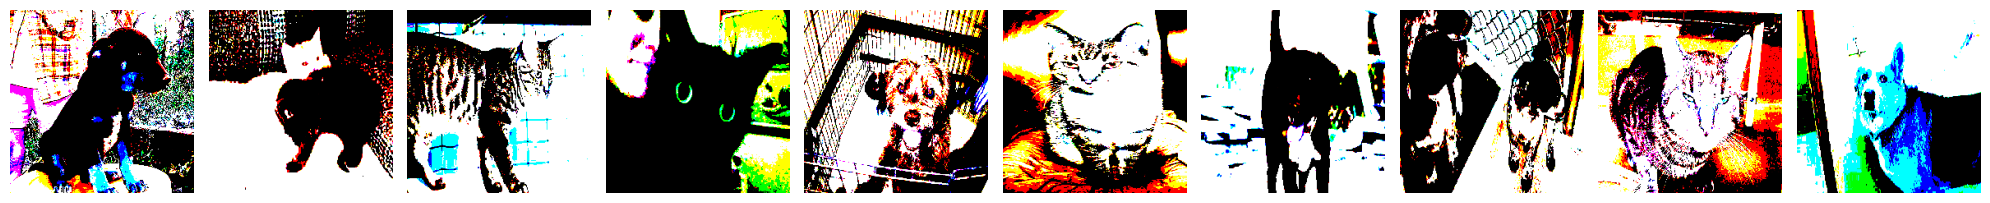

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [32]:
plotImages(imgs)
print(labels)

In [33]:
model = Sequential([
	Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224, 224, 3)),
	MaxPool2D(pool_size=(2, 2), strides=2),
	Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
  MaxPool2D(pool_size=(2, 2), strides=2),
  Flatten(),
  Dense(units=2, activation='softmax')
])

/home/genos/code/college/ml/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [34]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │       401,410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 420,802 (1.61 MB)

 Trainable params: 420,802 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10


/home/genos/code/college/ml/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 - 56s - 555ms/step - accuracy: 0.5740 - loss: 18.8800 - val_accuracy: 0.6000 - val_loss: 7.4857
Epoch 2/10
100/100 - 57s - 567ms/step - accuracy: 0.7620 - loss: 2.0126 - val_accuracy: 0.6150 - val_loss: 3.3707
Epoch 3/10
100/100 - 55s - 547ms/step - accuracy: 0.8680 - loss: 0.7989 - val_accuracy: 0.6750 - val_loss: 2.7574
Epoch 4/10
100/100 - 53s - 532ms/step - accuracy: 0.9450 - loss: 0.1930 - val_accuracy: 0.7000 - val_loss: 2.0068
Epoch 5/10
100/100 - 54s - 540ms/step - accuracy: 0.9890 - loss: 0.0321 - val_accuracy: 0.7000 - val_loss: 2.0672
Epoch 6/10
100/100 - 55s - 550ms/step - accuracy: 0.9990 - loss: 0.0032 - val_accuracy: 0.6550 - val_loss: 2.2005
Epoch 7/10
100/100 - 55s - 549ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.6950 - val_loss: 2.0392
Epoch 8/10
100/100 - 57s - 565ms/step - accuracy: 1.0000 - loss: 6.1760e-04 - val_accuracy: 0.7000 - val_loss: 2.0237
Epoch 9/10
100/100 - 56s - 558ms/step - accuracy: 1.0000 - loss: 4.9633e-04 - val_accuracy: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

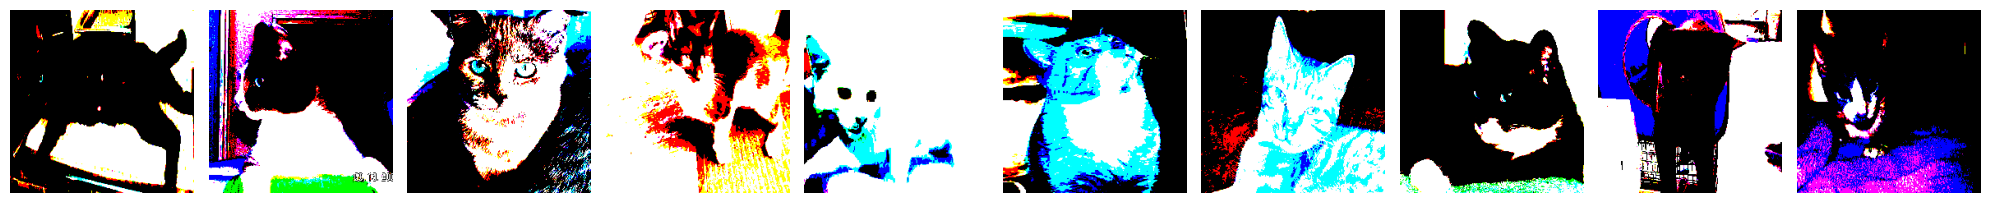

(array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], dtype=float32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32))

In [38]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
test_labels, test_batches.classes

In [39]:
predictions = model.predict(x=test_batches, verbose=0)

/home/genos/code/college/ml/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [40]:
predictions

array([[9.99999225e-01, 7.26165922e-07],
       [4.58864315e-06, 9.99995410e-01],
       [2.09611198e-06, 9.99997795e-01],
       [3.28423023e-01, 6.71576977e-01],
       [8.16367865e-01, 1.83632165e-01],
       [9.92791235e-01, 7.20873335e-03],
       [7.88407307e-03, 9.92115915e-01],
       [2.34690131e-04, 9.99765396e-01],
       [4.43819284e-01, 5.56180716e-01],
       [2.55933963e-04, 9.99744117e-01],
       [9.99977767e-01, 2.21451519e-05],
       [9.98579741e-01, 1.42021838e-03],
       [9.99999821e-01, 6.09199660e-08],
       [7.87328277e-03, 9.92126703e-01],
       [9.99803066e-01, 1.96843510e-04],
       [1.98210888e-02, 9.80178833e-01],
       [9.98816967e-01, 1.18305441e-03],
       [9.99983370e-01, 1.65844795e-05],
       [6.54153898e-03, 9.93458450e-01],
       [9.99975324e-01, 2.47116877e-05],
       [5.59702739e-02, 9.44029748e-01],
       [3.17592348e-04, 9.99682367e-01],
       [9.46063828e-03, 9.90539312e-01],
       [9.97102261e-01, 2.89760553e-03],
       [9.998743

In [41]:
np.round(predictions)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.

In [42]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [43]:
cm

array([[27, 23],
       [17, 33]])

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [45]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[27 23]
 [17 33]]


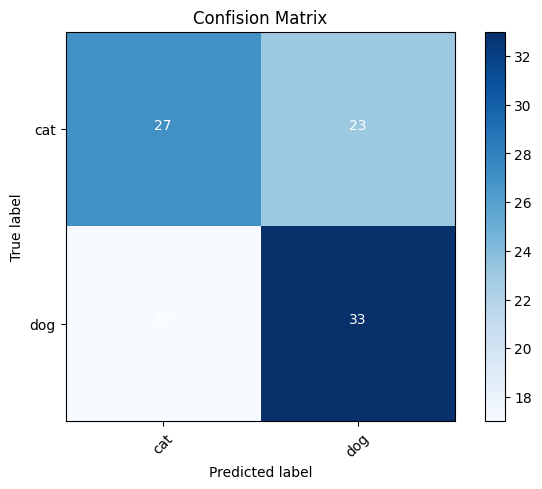

In [46]:
plot_confusion_matrix(cm, classes=['cat', 'dog'], title='Confision Matrix')